In [1]:
import matplotlib.pyplot as plt
from os import path
import numpy as np
import cv2 as cv
import sys
import os

# Required to import local modules
repo_root = path.abspath(path.join('..', '..'))
if repo_root not in sys.path:
    sys.path.append(repo_root)
    
# Our local modules
import ds_tools.calibration.calibrate as clb
import ds_tools.shared.cv_util as cv_util
import ds_tools.shared.util as util

# Overview:

We estimate the camera matrix and distortion coefficients by tracking the chessboard patterns in the video. In the end of the notebook, we try to undistort several frames from the video using calculated distortion coefficients.

# Determine preprocessing parameters

We're gonna visualise several several frames from the video an see how well we can detect the chessboard grid.

In [2]:
# Set the amount of inner corners in the chessboard pattern
vertical_corner_count = 7
horizontal_corner_count = 9
cb_size = (vertical_corner_count, horizontal_corner_count)

# Set brightness and contrast adjustment
brightness_adj = 100
contrast_adj = 0.5

# Option A) Choose the video (from the `data` folder) and how many frames
data_dir = util.get_data_dir()
video_path = path.join(data_dir, 'handheld-endoscope-calibration.avi')
frames_to_preview = 10

# Option B) Choose a folder with images that will be used for intrinsics calibration.
folder_path = path.join(data_dir, 'placenta_phantom_intrinsics_calib_right')

# Specify whether you want to use the folder or the video
use_video = False

## Preprocessing function:

In [3]:
def preprocess(in_frame):
    gray = cv.cvtColor(in_frame, cv.COLOR_RGB2GRAY)
    return gray
#     pp_gray = cv_util.apply_brightness_contrast(gray, brightness_adj, contrast_adj)
#     pp_gray = cv.medianBlur(pp_gray, 7)
#     return pp_gray

# Preview the frames

Chessboard pattern detected on 16 out of 16 frames.


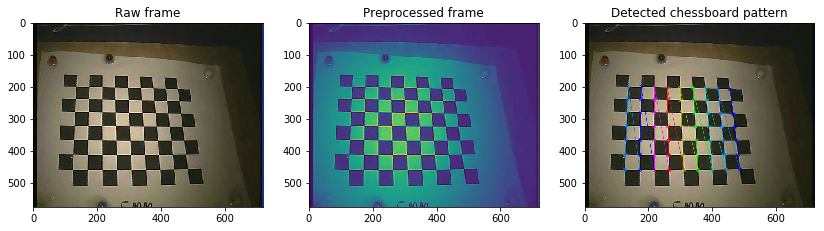

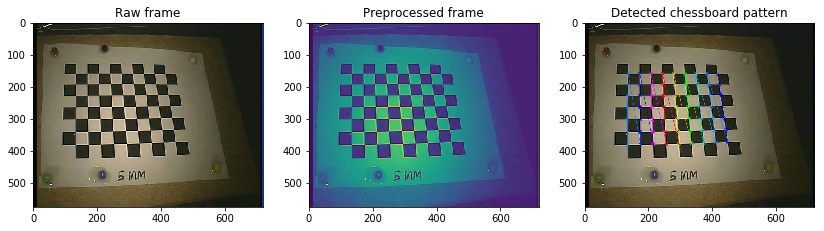

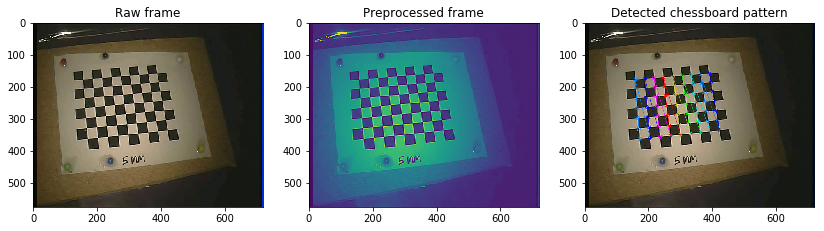

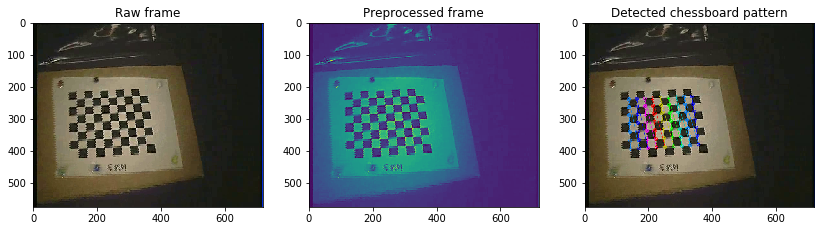

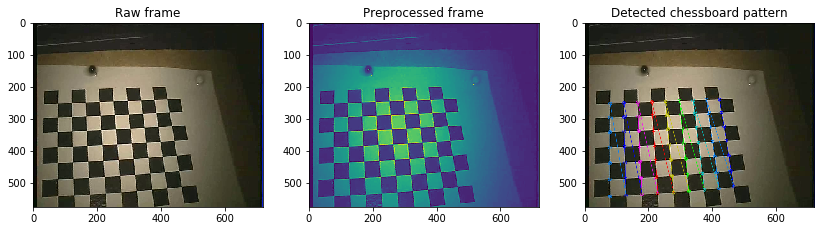

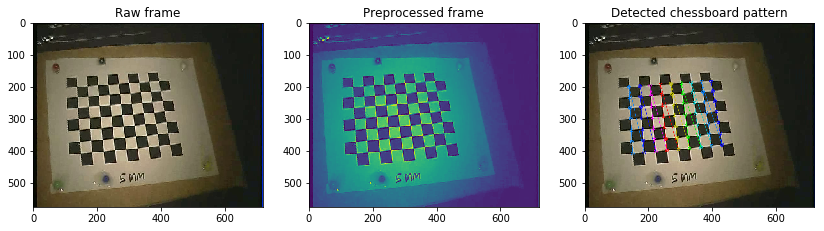

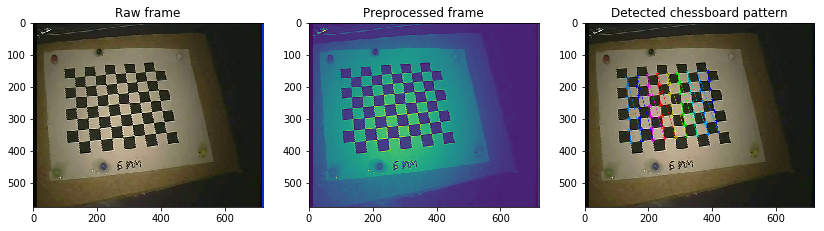

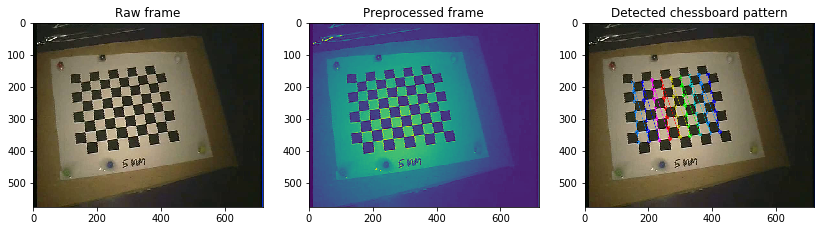

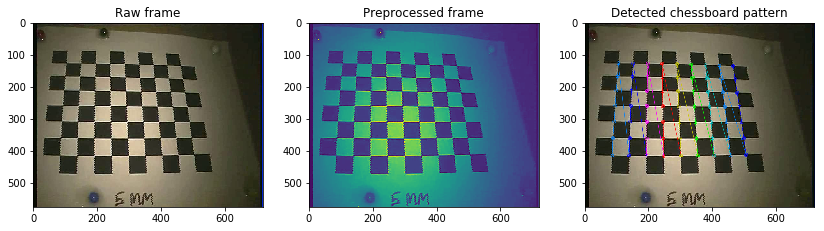

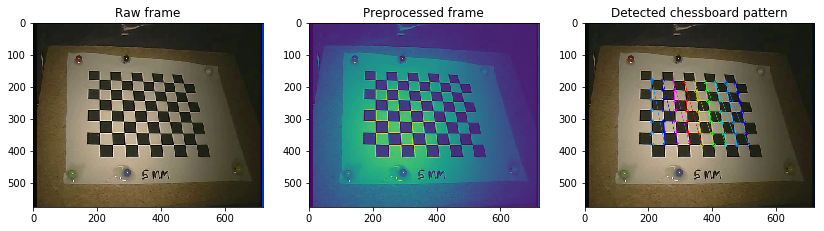

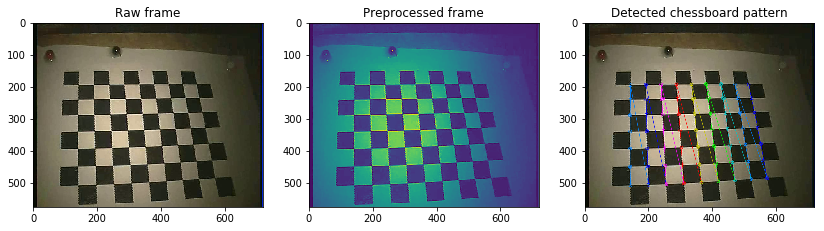

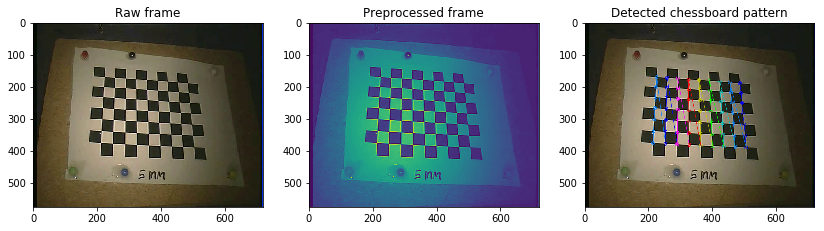

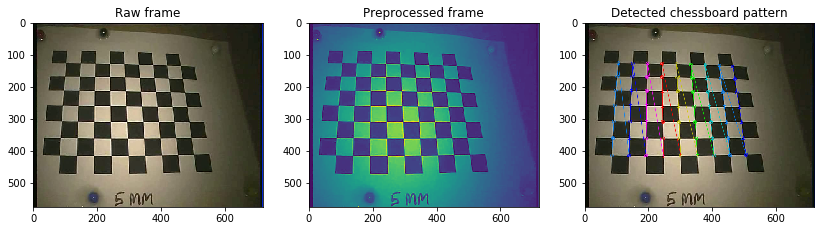

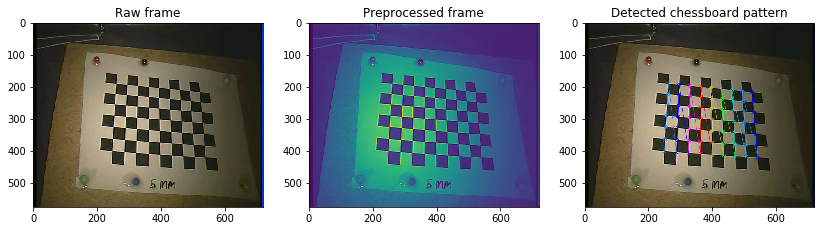

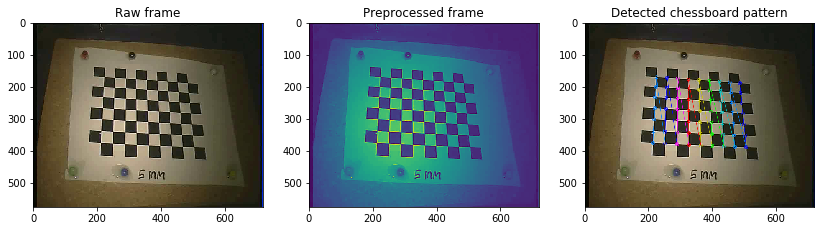

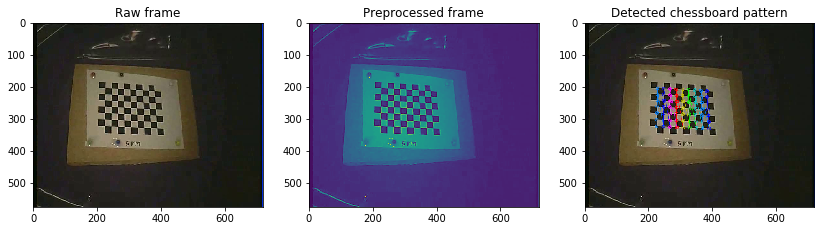

In [4]:
if use_video:
    cap = cv.VideoCapture(video_path)
    preview_frames = cv_util.pick_equidistant_frames(cap, frames_to_preview, 
                                                  convert_to_rgb=True)
else:
    images = cv_util.load_all_images(folder_path, convert_to_rgb=True)
    preview_frames = [image.copy() for image in images]
    
term_criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
flags = (cv.CALIB_CB_ADAPTIVE_THRESH
         + cv.CALIB_CB_FILTER_QUADS)

detection_count = 0
for frame in preview_frames:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 8))
    
    pp_frame = preprocess(frame)
    ret, corners = cv.findChessboardCorners(pp_frame, cb_size, flags)
    
    ax[0].set_title('Raw frame')
    ax[0].imshow(frame)
    ax[1].set_title('Preprocessed frame')
    ax[1].imshow(pp_frame)
    
    if ret:
        corners2 = cv.cornerSubPix(pp_frame, corners, (11, 11), (-1, -1), term_criteria)
        cb_img = cv.drawChessboardCorners(frame, cb_size, corners2, ret)
        ax[2].set_title('Detected chessboard pattern')
        ax[2].imshow(cb_img)
        detection_count += 1
    else:
        ax[2].set_title('No pattern detected')
        ax[2].imshow(frame)

print('Chessboard pattern detected on {} out of {} frames.'
      .format(detection_count, len(preview_frames)))

# Perform calibration on the video

In [5]:
# Minimum amount of frames with that detected pattern
frames_with_pattern = 100

if use_video:
    cb_pattern_source = cap
else:
    cb_pattern_source = images

(world_points,
 img_points) = clb.get_detected_chessboard_points(cb_pattern_source, cb_size, frames_with_pattern,
                                                  term_criteria=term_criteria,
                                                  preprocess_func=preprocess,
                                                  flags=flags
                                                 )

Got an array of frames as input, will use them to detect chessboard pattern.
Processed frame 16 out of 16   (found pattern on 16 frames, need 84 more)

In [6]:
cam_matrix, dist_coeffs, rvecs, tvecs = clb.calculate_camera_intrinsics(world_points,
                                                                        img_points,
                                                                        preview_frames[0]
                                                                       )

In [7]:
# Store the results in a JSON file
h, w = preview_frames[0].shape[:2]
intrinsics_file = path.join(data_dir, 'intrinsics.json')
util.save_intrinsics(intrinsics_file, cam_matrix, dist_coeffs, w, h)

# Print out the results
print('Camera matrix:')
print(cam_matrix)
print('\nDistortion coefficients:')
print(dist_coeffs)

Camera matrix:
[[808.57499622   0.         279.08611385]
 [  0.         873.90539342 275.42037795]
 [  0.           0.           1.        ]]

Distortion coefficients:
[[-0.31907407  0.61456551 -0.00293128  0.007044    0.11867111]]


# Rectify the preview frames

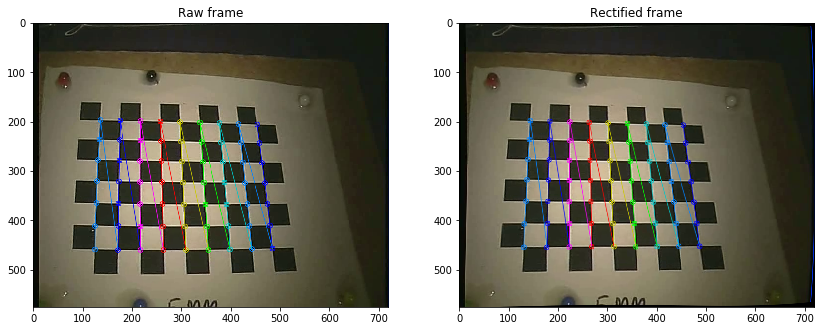

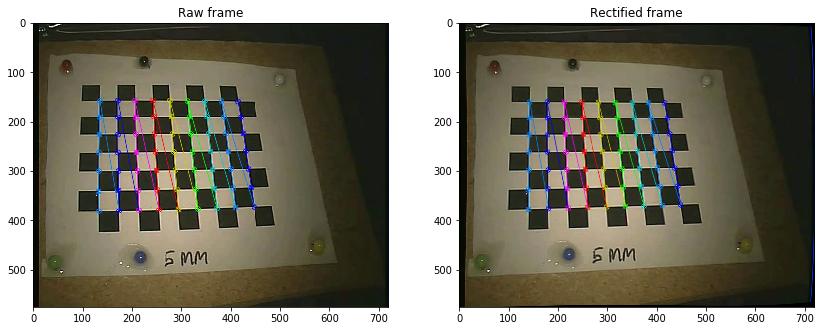

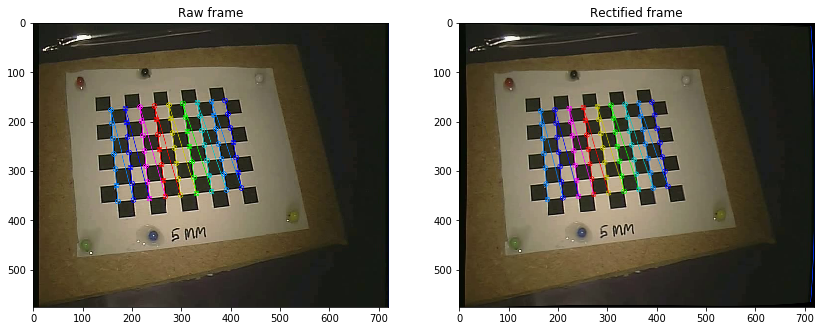

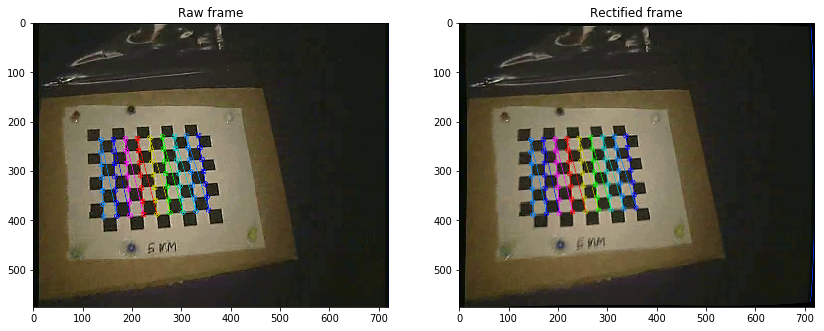

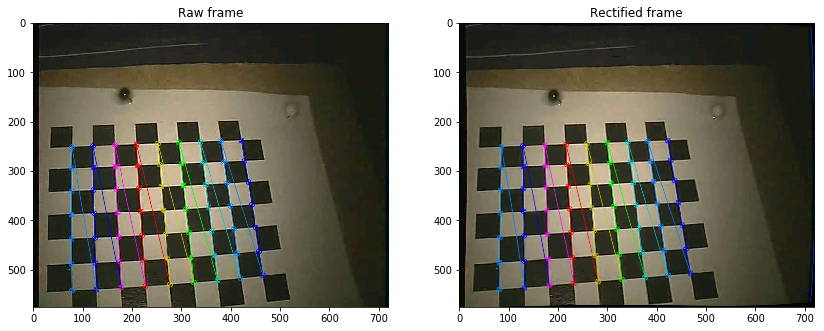

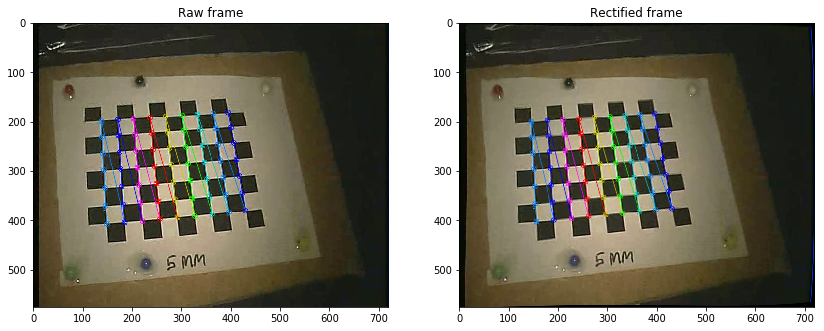

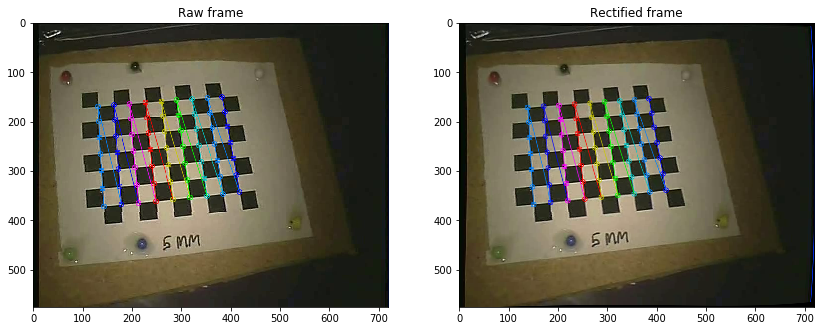

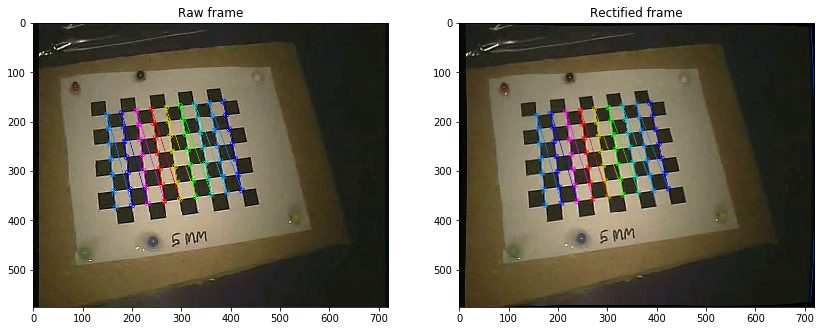

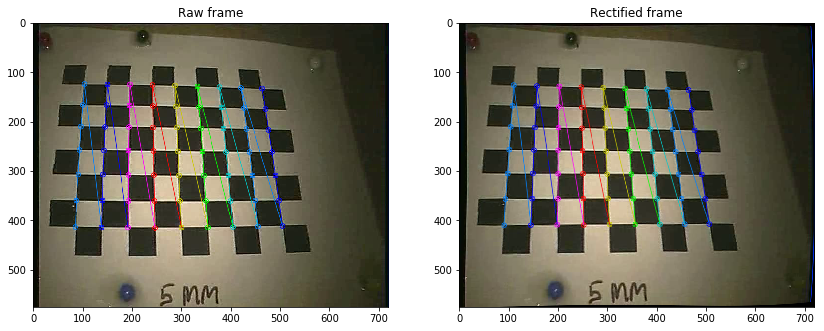

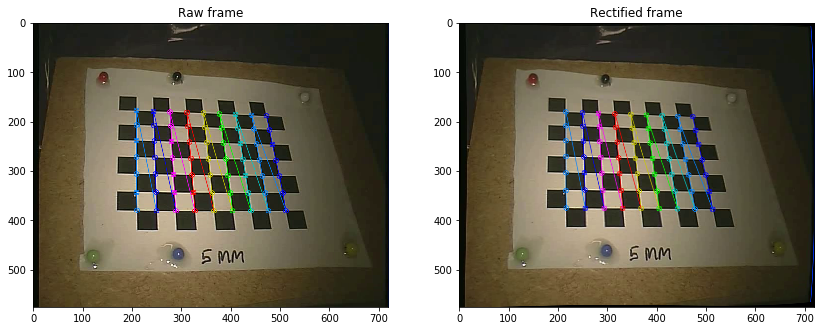

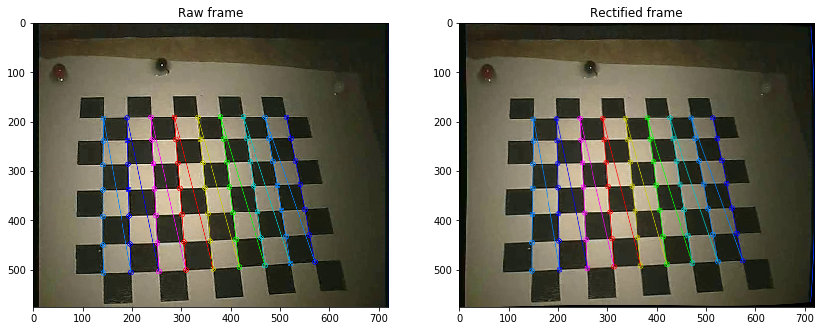

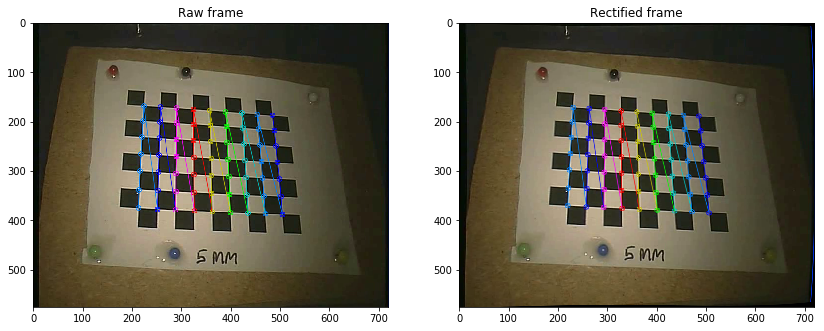

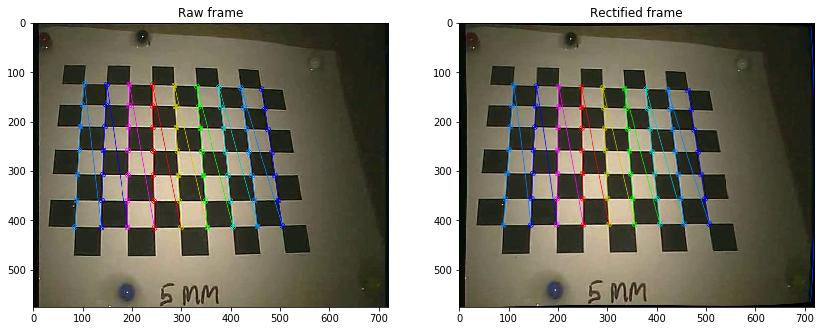

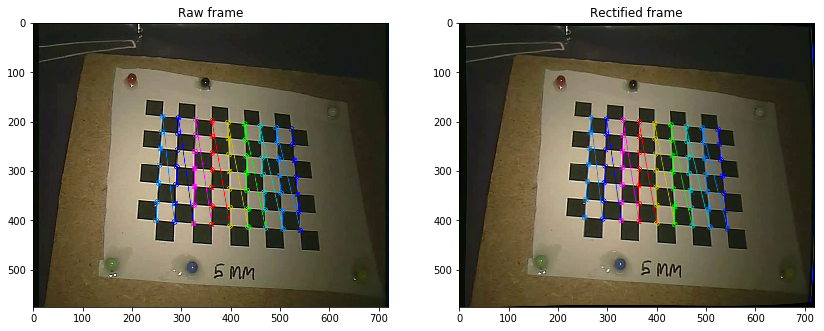

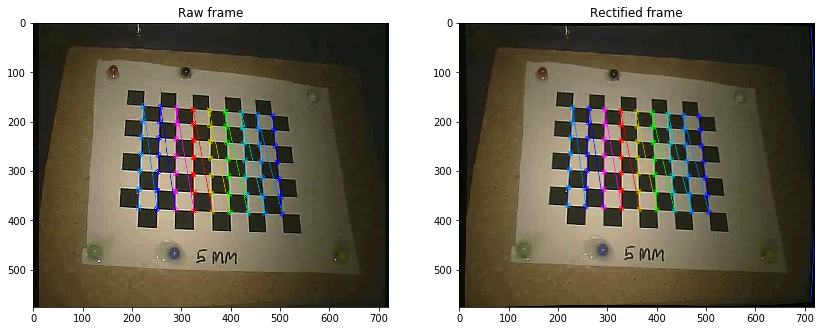

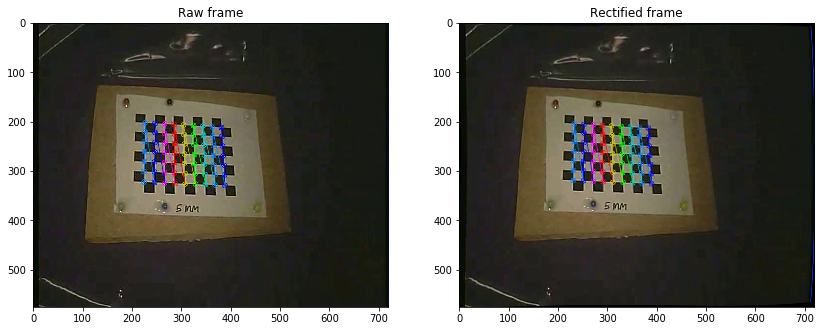

In [8]:
new_cam_matrix, roi = cv.getOptimalNewCameraMatrix(cam_matrix, dist_coeffs,
                                                   (w, h), 1, (w, h))
for frame in preview_frames:
    fixed_frame = cv.undistort(frame, cam_matrix, dist_coeffs, 
                               None, new_cam_matrix)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
    ax[0].set_title('Raw frame')
    ax[0].imshow(frame)
    ax[1].set_title('Rectified frame')
    ax[1].imshow(fixed_frame)